In [1]:
import pandas as pd
import json
import yaml
import numpy as np
import matplotlib.pyplot as plt
import config
import os

from preprocess.impute import impute_data

from sdmetrics.reports.single_table import QualityReport
from sdv.metadata import SingleTableMetadata
from sdmetrics.single_column import KSComplement

from synthcity.metrics.eval_statistical import KolmogorovSmirnovTest, InverseKLDivergence, SurvivalKMDistance
from synthcity.plugins.core.dataloader import GenericDataLoader, SurvivalAnalysisDataLoader

import seaborn as sns
from scipy.stats import ks_2samp
from skimage.exposure import match_histograms


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
def test_missing(real_baseline_df, datasets):
    missing = {'real': real_baseline_df.isna().mean()}

    for name, synth_df in datasets.items():
        missing[name] = synth_df.isna().mean()

    missing_df =pd.DataFrame(missing)
    # missing_df.loc['mean'] = missing_df.mean()
    return missing_df


In [ ]:
with open(config.COLUMNS_CLASS, 'r') as yaml_file:
    column_class = yaml.load(yaml_file, Loader=yaml.FullLoader)

data_impute_method = 'add_missing'
impute_method = 'mice'
apply_histogram_equalize = False

real_baseline_df = pd.read_parquet(config.BASELINE_COMBINE_FILE).reset_index()

cgan_df = pd.read_csv(config.CGAN_SYNTHETIC_BASELINE + data_impute_method + '.csv')
survadgan_df =  pd.read_csv(config.SURVADGAN_SYNTHETIC_BASELINE + data_impute_method + '.csv')
tvae_df = pd.read_csv(config.TVAE_SYNTHETIC_BASELINE + data_impute_method + '.csv')
adgan_df = pd.read_csv(config.ADGAN_SYNTHETIC_BASELINE + data_impute_method + '.csv')
ddpm_df = pd.read_csv(config.DDPM_SYNTHETIC_BASELINE + data_impute_method + '.csv')
nflow_df = pd.read_csv(config.NFLOW_SYNTHETIC_BASELINE + data_impute_method + '.csv')

real_train_idx = np.load(config.INDEX_TRAIN )
real_val_idx = np.load(config.INDEX_VAL)
real_test_idx = np.load(config.INDEX_TEST )

survadgan_train_idx = np.load(config.SURVADGAN_INDEX_TRAIN+ data_impute_method + '.npy')
survadgan_val_idx = np.load(config.SURVADGAN_INDEX_VAL+ data_impute_method + '.npy')
survadgan_test_idx = np.load(config.SURVADGAN_INDEX_TEST+ data_impute_method + '.npy')

cgan_train_idx = np.load(config.CGAN_INDEX_TRAIN+ data_impute_method + '.npy')
cgan_val_idx = np.load(config.CGAN_INDEX_VAL+ data_impute_method + '.npy')
cgan_test_idx = np.load(config.CGAN_INDEX_TEST+ data_impute_method + '.npy')

tvae_train_idx = np.load(config.TVAE_INDEX_TRAIN+ data_impute_method + '.npy')
tvae_val_idx = np.load(config.TVAE_INDEX_VAL+ data_impute_method + '.npy')
tvae_test_idx = np.load(config.TVAE_INDEX_TEST+ data_impute_method + '.npy')

adgan_train_idx = np.load(config.ADGAN_INDEX_TRAIN+ data_impute_method + '.npy')
adgan_val_idx = np.load(config.ADGAN_INDEX_VAL+ data_impute_method + '.npy')
adgan_test_idx = np.load(config.ADGAN_INDEX_TEST+ data_impute_method + '.npy')

ddpm_train_idx = np.load(config.DDPM_INDEX_TRAIN+ data_impute_method + '.npy')
ddpm_val_idx = np.load(config.DDPM_INDEX_VAL+ data_impute_method + '.npy')
ddpm_test_idx = np.load(config.DDPM_INDEX_TEST+ data_impute_method + '.npy')

nflow_train_idx = np.load(config.NFLOW_INDEX_TRAIN+ data_impute_method + '.npy')
nflow_val_idx = np.load(config.NFLOW_INDEX_VAL+ data_impute_method + '.npy')
nflow_test_idx = np.load(config.NFLOW_INDEX_TEST+ data_impute_method + '.npy')

#process to make columns match
cgan_df.columns = [col.replace('_1', '') for col in cgan_df.columns]
tvae_df.columns = [col.replace('_1', '') for col in tvae_df.columns]
survadgan_df.columns = [col.replace('_1', '') for col in survadgan_df.columns]
adgan_df.columns = [col.replace('_1', '') for col in adgan_df.columns]
ddpm_df.columns = [col.replace('_1', '') for col in ddpm_df.columns]
nflow_df.columns = [col.replace('_1', '') for col in nflow_df.columns]

real_baseline_df = real_baseline_df.drop(columns=['admit'], errors='ignore')
column_order = real_baseline_df.columns.tolist()
adgan_df = adgan_df[column_order].set_index('ENC_HN')
cgan_df = cgan_df[column_order].set_index('ENC_HN')
survadgan_df = survadgan_df[column_order].set_index('ENC_HN')
tvae_df = tvae_df[column_order].set_index('ENC_HN')
ddpm_df = ddpm_df[column_order].set_index('ENC_HN')
nflow_df = nflow_df[column_order].set_index('ENC_HN')
real_baseline_df = real_baseline_df[column_order].set_index('ENC_HN')

if apply_histogram_equalize:
    use_index = np.concatenate([real_train_idx, real_val_idx])

    adgan_df['Days'] = match_histograms(adgan_df['Days'].to_numpy(), real_baseline_df['Days'][use_index].to_numpy())
    cgan_df['Days'] = match_histograms(cgan_df['Days'].to_numpy(), real_baseline_df['Days'][use_index].to_numpy())
    survadgan_df['Days'] = match_histograms(survadgan_df['Days'].to_numpy(), real_baseline_df['Days'][use_index].to_numpy())
    tvae_df['Days'] = match_histograms(tvae_df['Days'].to_numpy(), real_baseline_df['Days'][use_index].to_numpy())
    ddpm_df['Days'] = match_histograms(ddpm_df['Days'].to_numpy(), real_baseline_df['Days'][use_index].to_numpy())
    nflow_df['Days'] = match_histograms(nflow_df['Days'].to_numpy(), real_baseline_df['Days'][use_index].to_numpy())

unimputed_real_df = real_baseline_df.copy()

unimputed_datasets = {
    'TVAE': tvae_df.copy(),
    'SurvivalGAN': survadgan_df.copy(),
    'ADSGAN': adgan_df.copy(),
    # 'CTGAN': cgan_df.copy(),
    'TabDDPM': ddpm_df.copy(),
    'NFlow': nflow_df.copy()
}

missing_df = test_missing(real_baseline_df, unimputed_datasets)

adgan_df = impute_data(adgan_df, adgan_train_idx, adgan_val_idx, adgan_test_idx, method=impute_method)
cgan_df = impute_data(cgan_df, cgan_train_idx, cgan_val_idx, cgan_test_idx, method=impute_method)
survadgan_df = impute_data(survadgan_df, survadgan_train_idx, survadgan_val_idx, survadgan_test_idx, method=impute_method)
tvae_df = impute_data(tvae_df, tvae_train_idx, tvae_val_idx, tvae_test_idx, method=impute_method)
ddpm_df = impute_data(ddpm_df, ddpm_train_idx, ddpm_val_idx, ddpm_test_idx, method=impute_method)
nflow_df = impute_data(nflow_df, nflow_train_idx, nflow_val_idx, nflow_test_idx, method=impute_method)

real_baseline_df = real_baseline_df
real_baseline_df = impute_data(real_baseline_df, real_train_idx, real_val_idx, real_test_idx, method = impute_method)
real_baseline_df = real_baseline_df.reset_index()
real_baseline_df['dead'] = real_baseline_df['dead'].astype(int)
real_baseline_df = real_baseline_df.drop(columns=['admit'], errors='ignore')

adgan_df['dead'] = adgan_df['dead'].astype(int)
cgan_df['dead'] = cgan_df['dead'].astype(int)
survadgan_df['dead'] = survadgan_df['dead'].astype(int)
tvae_df['dead'] = tvae_df['dead'].astype(int)
ddpm_df['dead'] = ddpm_df['dead'].astype(int)
nflow_df['dead'] = nflow_df['dead'].astype(int)


real = GenericDataLoader(real_baseline_df, target_column="dead", time_to_event_column = 'Days')
cgan = GenericDataLoader(cgan_df, target_column="dead", time_to_event_column = 'Days')
tvae = GenericDataLoader(tvae_df, target_column="dead", time_to_event_column = 'Days')
survadgan = GenericDataLoader(survadgan_df, target_column="dead", time_to_event_column = 'Days')
adgan = GenericDataLoader(adgan_df, target_column="dead", time_to_event_column = 'Days')
ddpm = GenericDataLoader(ddpm_df, target_column="dead", time_to_event_column = 'Days')
nflow = GenericDataLoader(nflow_df, target_column="dead", time_to_event_column = 'Days')



datasets = {
    'TVAE': tvae_df,
    'SurvivalGAN': survadgan_df,
    'ADSGAN': adgan_df,
    # 'CTGAN': cgan_df,
    'TabDDPM': ddpm_df,
    'NFlow': nflow_df,
}

continuous_cols = [col for col in column_class['continuous'] if col in real_baseline_df.columns]
categorical_cols = [col for col in column_class['discrete'] if col in real_baseline_df.columns]

demographic_cols = ['Gender']
diagnosis_cols = ['HT', 'DM', 'AF', 'CKD']
medication_cols = ['ACEI', 'ARBs', 'ARNI', 'BB', 'Ivabradine', 'MRA', 'SGLT2i', 'Statin', 'furosemide', 'thiazide']
event_cols = ['dead']


# Distribution

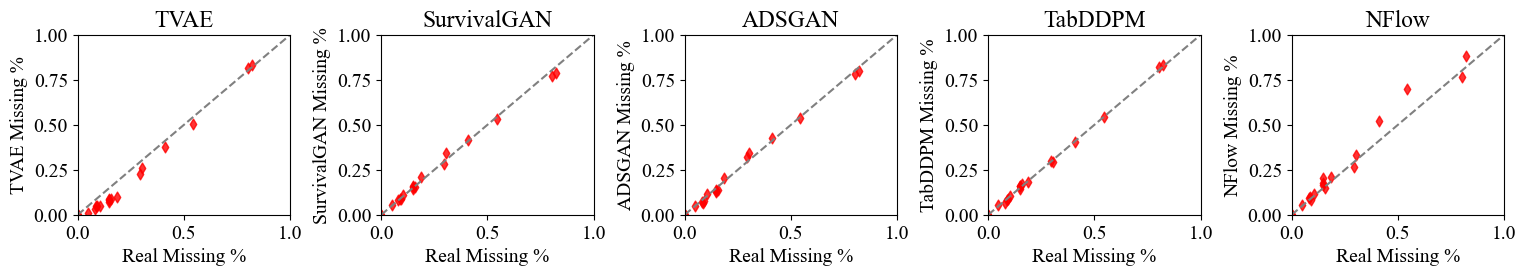

In [4]:
real_demo_missing = unimputed_real_df[continuous_cols].isnull().mean().values

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  # Default font size

# Create the plot
scale = 1.3
fig, axes = plt.subplots(1, len(unimputed_datasets), figsize=(4 * len(unimputed_datasets)/scale, 4/scale))

for ax, (name, synth_df) in zip(axes, unimputed_datasets.items()):
    # Calculate missing data percentages for synthetic data
    demo_missing = synth_df[continuous_cols].isnull().mean().values


    # Create scatter plots for each category
    ax.scatter(real_demo_missing, demo_missing, color='red', alpha=0.8, s=30, marker='d')

    # Add diagonal reference line
    ax.plot([0, 1], [0, 1], ls='--', color='gray')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"{name}")
    ax.set_xlabel("Real Missing %")
    ax.set_ylabel(f"{name} Missing %")
    ax.tick_params(axis='both')

# Add legend
# axes[0].scatter([], [], marker='d', color='red', label='Gender')


# fig.legend(loc='lower center', ncol=4, fontsize=8, edgecolor='black')

plt.tight_layout(rect=[0, 0.03, 1, 1]) 
plt.savefig("results/missing_data.png", dpi=800, bbox_inches='tight')
plt.show()

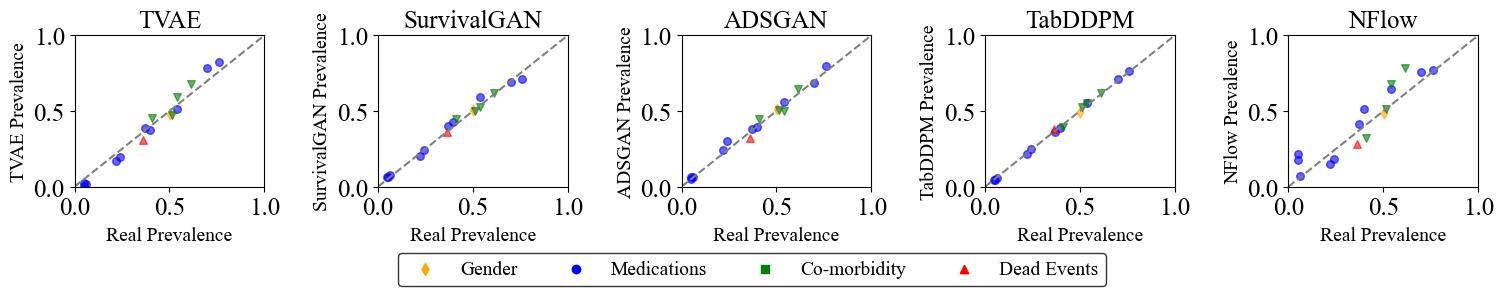

In [5]:
real_demo_prevalence = real_baseline_df[demographic_cols].mean().values
real_medication_prevalence = real_baseline_df[medication_cols].mean().values
real_diagnosis_prevalence = real_baseline_df[diagnosis_cols].mean().values
real_event_prevalence = real_baseline_df[event_cols].mean().values

prevalence = {'real': real_baseline_df[categorical_cols].mean()}
datasets = {
    'TVAE': tvae_df,
    'SurvivalGAN': survadgan_df,
    'ADSGAN': adgan_df,
    # 'CTGAN': cgan_df,
    'TabDDPM': ddpm_df,
    'NFlow': nflow_df,
}
for name, synth_df in datasets.items():
    prevalence[name] = synth_df[categorical_cols].mean()

prevalence_df = pd.DataFrame(prevalence)

scale = 1.3
fig, axes = plt.subplots(1, len(datasets), figsize=(4 * len(datasets)/scale, 4/scale))

for ax, (name, synth_df) in zip(axes, datasets.items()):
    demo_prevalence = synth_df[demographic_cols].mean().values
    medication_prevalence = synth_df[medication_cols].mean().values
    diagnosis_prevalence = synth_df[diagnosis_cols].mean().values
    event_prevalence = synth_df[event_cols].mean().values

    ax.scatter(real_demo_prevalence, demo_prevalence, color='orange', alpha=0.6, s=30, marker='d')
    ax.scatter(real_medication_prevalence, medication_prevalence, color='blue', alpha=0.6, s=30)
    ax.scatter(real_diagnosis_prevalence, diagnosis_prevalence, color='green', alpha=0.6, s=30, marker='v')
    ax.scatter(real_event_prevalence, event_prevalence, color='red', alpha=0.6, s=30,marker='^' )

    ax.plot([0, 1], [0, 1], ls='--', color='gray')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"{name}", fontsize=18)
    ax.set_xlabel("Real Prevalence", fontsize=14)
    ax.set_ylabel(f"{name} Prevalence", fontsize=14)
    ax.tick_params(axis='both', labelsize=18)
    

axes[0].scatter([], [], marker='d', color='orange', label='Gender')
axes[0].scatter([], [], marker='o', color='blue', label='Medications')
axes[0].scatter([], [], marker='s', color='green', label='Co-morbidity')
axes[0].scatter([], [], marker='^', color='red', label='Dead Events')

fig.legend(loc='lower center', ncol=4, fontsize=14, edgecolor='black')

plt.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.savefig("results/prevalence.png", dpi=800, bbox_inches='tight')
plt.show()

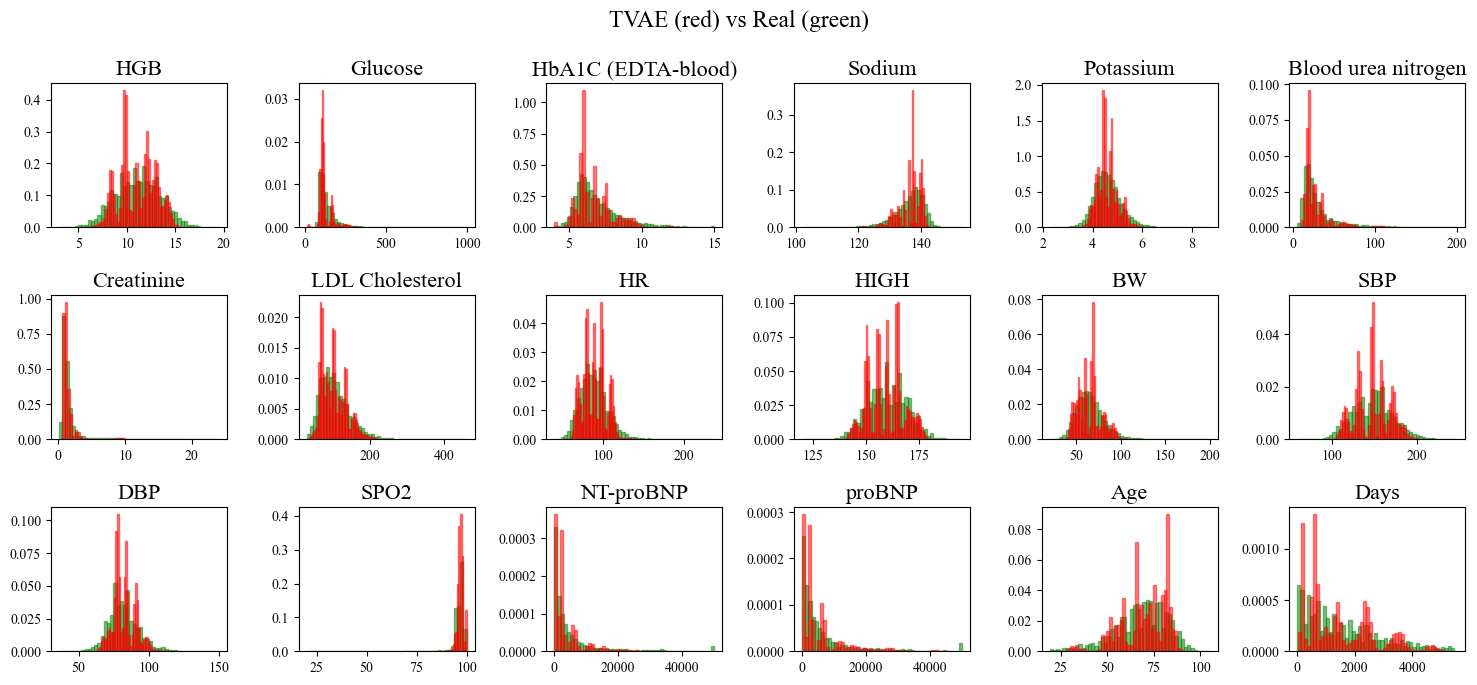

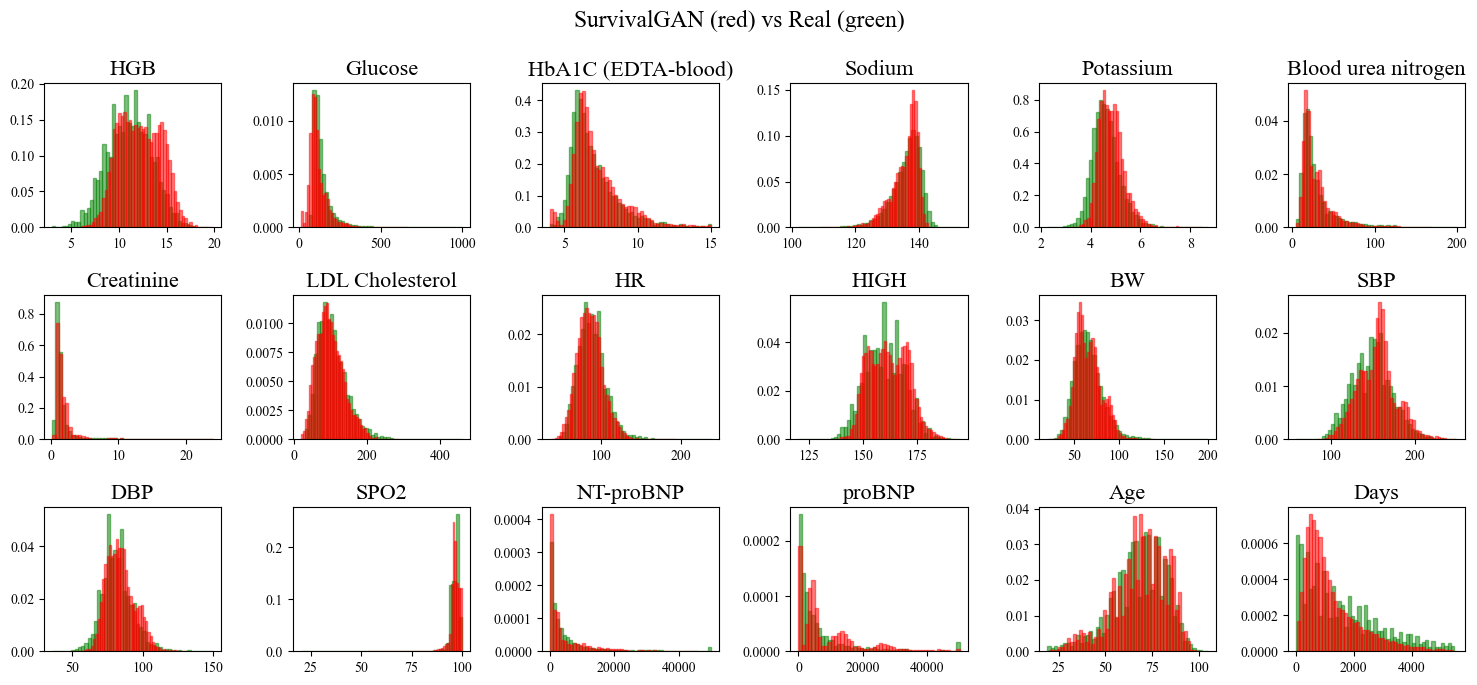

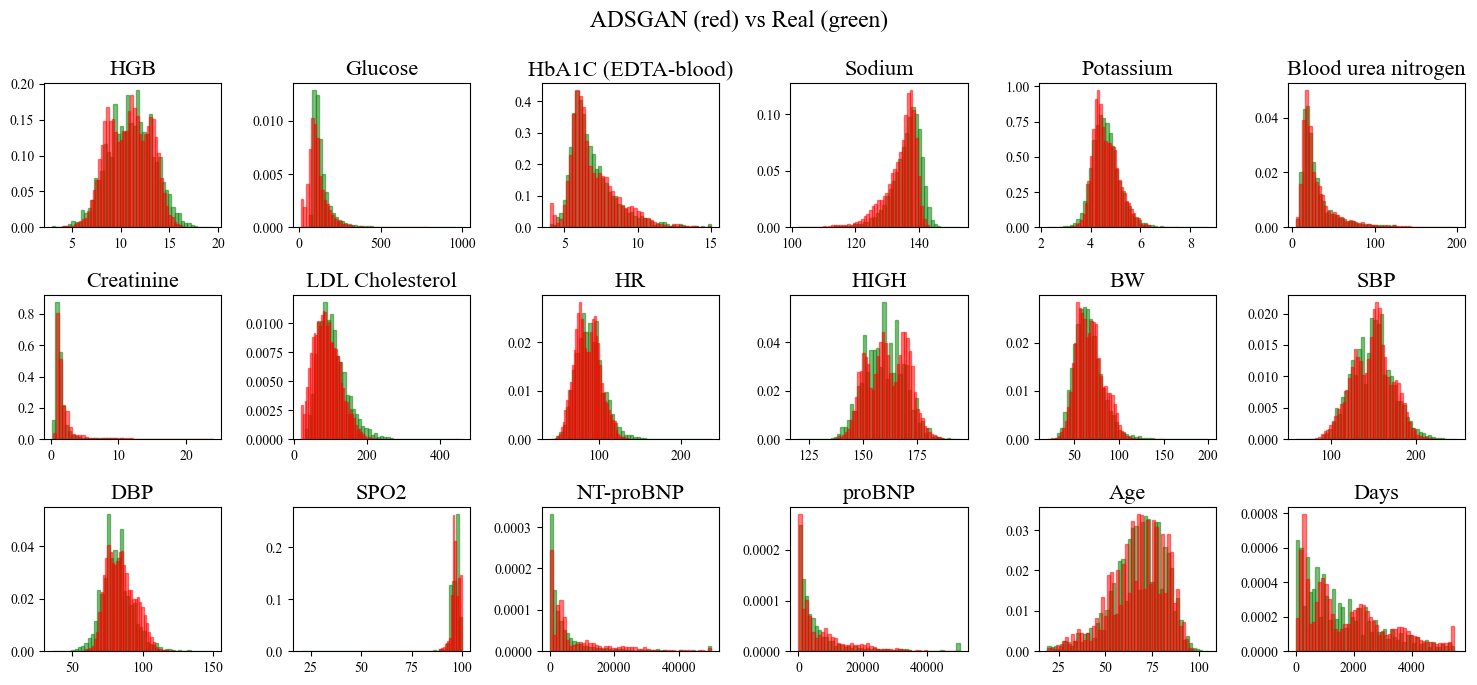

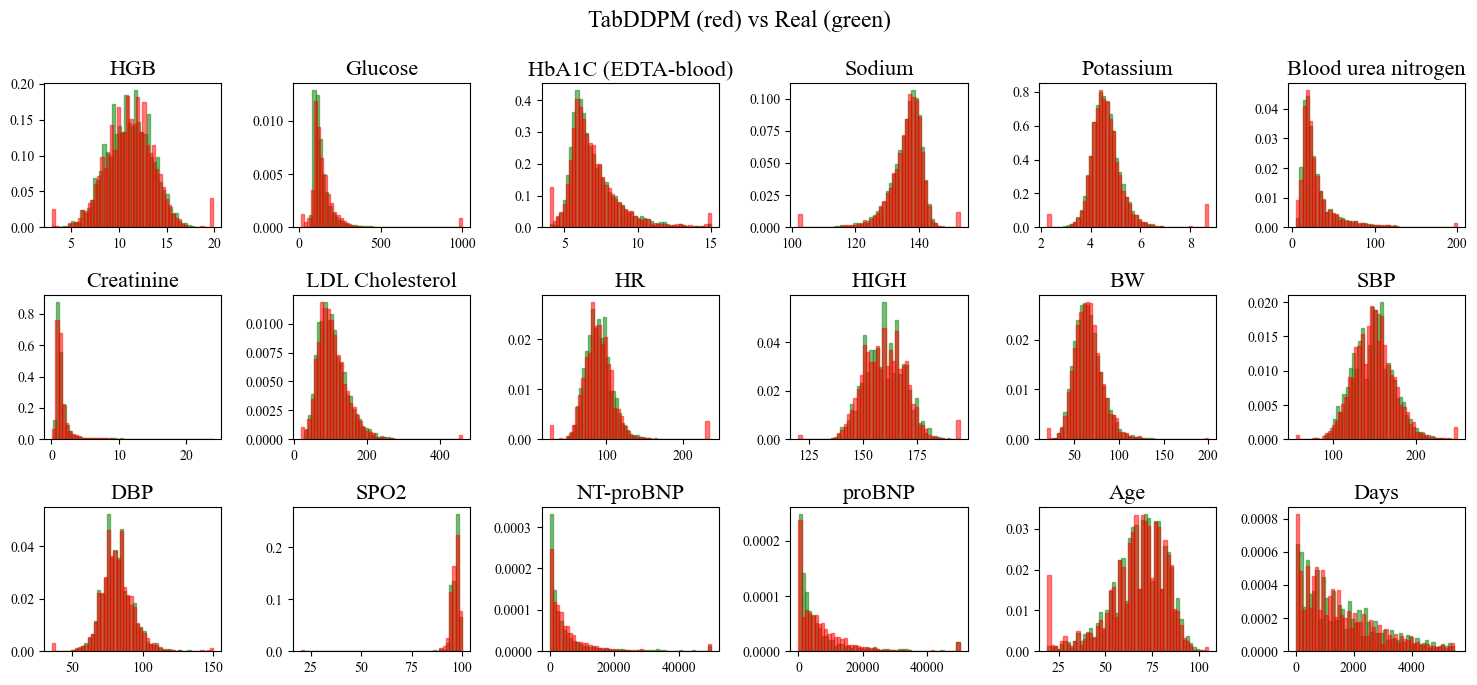

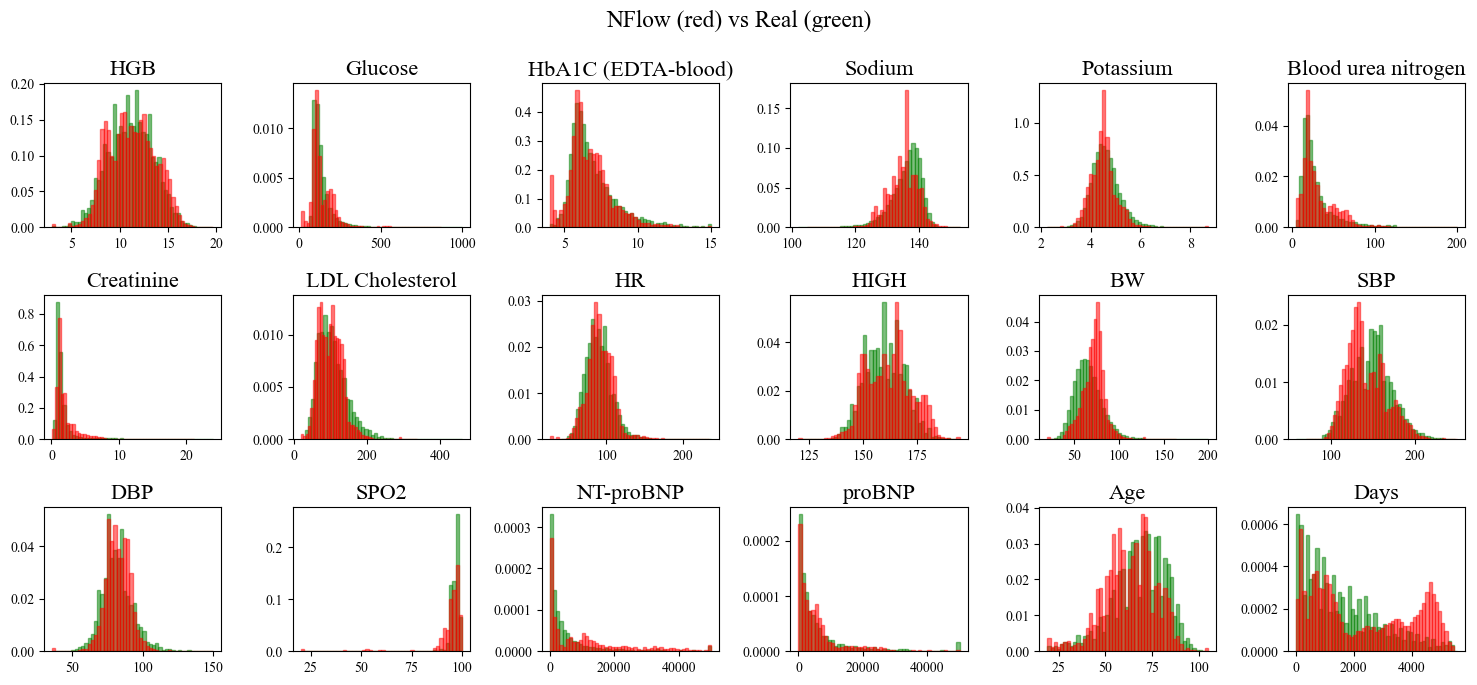

In [6]:
mean_ks = {}
scale = 1.3
figure_width = 15  # Adjust this value to change overall width
figure_height = 7  # Adjust this value to change overall height

for synth_name, synth_df in unimputed_datasets.items():
    n_cols = 6
    n_rows = int(np.ceil(len(continuous_cols) / n_cols))

    # Option 1: Fixed figure size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figure_width, figure_height), sharey=False, sharex=False)
    
    # Option 2: Scaled figure size (alternative - comment out Option 1 and uncomment this)
    # fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols/scale, 4 * n_rows/scale), sharey=False, sharex=False)
    
    axes = axes.flatten()

    ks = []

    for idx, col in enumerate(continuous_cols):
        ax = axes[idx]

        real_col = unimputed_real_df[col].dropna()
        synth_col = synth_df[col].dropna()
        ax.hist(real_col, bins=50, alpha=0.5, label='Real', color='green', edgecolor='green', density = True)
        ax.hist(synth_col, bins=50, alpha=0.5, label=synth_name, color='red', edgecolor='red', density = True)

        sd_ks = KSComplement.compute(real_col, synth_col)
        ks.append(sd_ks)

        missing_real = unimputed_real_df[col].isna().mean() * 100
        missing_synth = synth_df[col].isna().mean() * 100
   
        ax.set_title(f"{col}", fontsize=16, color='black')
        # ax.set_title(f"{col}\nMissing: R={missing_real:.1f}%, S={missing_synth:.1f}%", fontsize=8)

        # Legend removed - this line was deleted
        ax.tick_params(axis='x', labelsize=10, colors='black')
        ax.tick_params(axis='y', labelsize=10, colors='black')

    mean_ks[synth_name] = np.mean(ks)

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    if synth_name == 'DDPM':
        synth_name = 'TabDDPM'
    plt.suptitle(f"{synth_name} (red) vs Real (green)")
    plt.tight_layout()
    os.makedirs("results", exist_ok=True)
    plt.savefig(f"results/{synth_name}.png", dpi=800, bbox_inches='tight')
    plt.show()

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, fisher_exact, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

def compare_datasets(df1, df2, categorical_cols=None, alpha=0.05):

    common_cols = list(set(df1.columns) & set(df2.columns))
    
    # Auto-detect categorical columns if not specified
    if categorical_cols is None:
        categorical_cols = [col for col in common_cols 
                          if df1[col].dtype in ['object', 'category'] or 
                             df2[col].dtype in ['object', 'category']]
    
    p_values = {}
    
    for col in common_cols:
        if col in categorical_cols:

            data1 = df1[col].dropna()
            data2 = df2[col].dropna()
            
            if len(data1) == 0 or len(data2) == 0:
                raise ValueError(f"Column {col} has no data in one of the datasets.")
                
            # Create contingency table
            combined = pd.concat([
                pd.DataFrame({'value': data1, 'group': 1}),
                pd.DataFrame({'value': data2, 'group': 2})
            ])
            contingency = pd.crosstab(combined['value'], combined['group'])
            
            if contingency.shape == (2, 2):
                # Use Fisher's exact test for 2x2 tables
                _, p_val = fisher_exact(contingency)
            else:
                # Use chi-square test for larger contingency tables
                # Check if expected frequencies are adequate for chi-square test
                chi2_stat, p_val, dof, expected = chi2_contingency(contingency)
                
                # Check assumptions: expected frequencies should be >= 5 in at least 80% of cells
                low_expected = (expected < 5).sum()
                total_cells = expected.size
                
                if low_expected / total_cells > 0.2:
                    warnings.warn(f"Column {col}: {low_expected}/{total_cells} cells have expected "
                                f"frequency < 5. Chi-square test may not be reliable.")
                
                
        else:
            # Continuous variables - t-test or Mann-Whitney
            data1 = df1[col].dropna()
            data2 = df2[col].dropna()
            
            if len(data1) < 3 or len(data2) < 3:
                raise ValueError(f"Column {col} has too few data points in one of the datasets.")
            
            # Test normality
            normal1 = shapiro(data1)[1] > alpha 
            normal2 = shapiro(data2)[1] > alpha 
            
            if normal1 and normal2:
                
                _, p_val = ttest_ind(data1, data2, equal_var=False)

            else:
                _, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
        
        p_values[col] = p_val < alpha
        p_values[col] = p_values[col] if not p_values[col] else np.nan
        
        # Test for difference in missing data proportions
        missing1 = df1[col].isna().sum()
        missing2 = df2[col].isna().sum()
        total1 = len(df1)
        total2 = len(df2)
        
        # Create contingency table for missing data test
        missing_contingency = np.array([
            [missing1, total1 - missing1],
            [missing2, total2 - missing2]
        ])
        
        # Test if there's any missing data to compare
        if missing1 > 0 or missing2 > 0:
  
            _, missing_p = fisher_exact(missing_contingency)
            p_values[f"{col}_missing"] = missing_p < alpha
            p_values[f"{col}_missing"] = p_values[f"{col}_missing"] if not p_values[f"{col}_missing"] else np.nan
        elif col in categorical_cols and col in ['Age']:
            # No missing data in either dataset
            p_values[f"{col}_missing"] = np.nan
        elif missing1 == 0:
            # No missing data in either dataset
            p_values[f"{col}_missing"] = np.nan
        else:
            raise ValueError(f"Column {col} is not categorical but has no missing data to compare.")
        
    return pd.Series(p_values)



In [8]:
results = {}

for name, df in unimputed_datasets.items():
    results[name] = compare_datasets(real_baseline_df, df, categorical_cols=categorical_cols)


def format_continuous(col, df, result_dict = None):
    mean = df[col].mean()
    std = df[col].std()
    missing = df[col].isna().mean() 
    if result_dict is not None:
        return f"{mean:.1f} ± {std:.1f}{'*' if result_dict[col] == False else ''}\n ({missing:.2f}{'*' if result_dict[f'{col}_missing'] == False else ''})"
    else:
        return f"{mean:.1f} ± {std:.1f}\n ({missing:.2f})"

def format_categorical(col, df, result_dict = None):
    prevalence = df[col].mean()  
    missing = df[col].isna().mean()
    if result_dict is not None:
        return f"{prevalence:.2f}{'*' if result_dict[col] == False else ''}"
    return f"{prevalence:.2f}"

feature_report_df = pd.DataFrame(index=continuous_cols + categorical_cols)
feature_report_df['Real'] = [format_continuous(col, unimputed_real_df) if col in continuous_cols else format_categorical(col, unimputed_real_df) for col in feature_report_df.index]

for name, df in unimputed_datasets.items():
    feature_report_df[name] = [format_continuous(col, df, result_dict = results[name]) if col in continuous_cols else format_categorical(col, df, result_dict = results[name]) for col in feature_report_df.index]

feature_report_df.to_csv("results/feature_report.csv", encoding='utf-8-sig')

# dimension-wise metrics and column-wise correlations

In [9]:
def prepare_sdv(df):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df)
    return df, metadata

real_df = real_baseline_df.copy()  
real_df = real_df.drop(columns=['ENC_HN'], errors='ignore')
results = []
datasets = {
    'TVAE': tvae_df,
    'SurvivalGAN': survadgan_df,
    'ADSGAN': adgan_df,
    # 'CTGAN': cgan_df,
    'TabDDPM': ddpm_df,
    'NFlow': nflow_df,
}
for name, synth_df in datasets.items():
    synth_df['dead'] = synth_df['dead'].astype(bool)
    synth_df, metadata = prepare_sdv(synth_df)

    # Quality Report
    quality = QualityReport()
    quality.generate(real_df, synth_df, metadata.to_dict())
    quality_score = round(quality.get_score(), 4)
    quality_props = quality.get_properties()

    # diagnostic = DiagnosticReport()
    # diagnostic.generate(real_df, synth_df, metadata.to_dict())
    # diagnostic_score = round(diagnostic.get_score(), 4)
    # diagnostic_props = diagnostic.get_properties()

    row = {
        "Model": name,
        # "Quality Score": quality_score,
        # "Diagnostic Score": diagnostic_score,
    }

    for _, row_prop in quality_props.iterrows():
        if row_prop['Property'] == 'Column Pair Trends':
            row[f"Column-wise correlation"] = round(row_prop['Score'], 4)
        elif row_prop['Property'] == 'Column Shapes':
            row[f"Dimension-wise metrics"] = round(row_prop['Score'], 4)
        else:
            raise ValueError(f"Unexpected property: {row_prop['Property']}")

    # for _, row_prop in diagnostic_props.iterrows():
    #     row[f"Diagnostic:{row_prop['Property']}"] = round(row_prop['Score'], 4)

    results.append(row)



summary_df = pd.DataFrame(results)
summary_df


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 35/35 [00:00<00:00, 134.08it/s]|
Column Shapes Score: 92.66%

(2/2) Evaluating Column Pair Trends: |██████████| 595/595 [00:02<00:00, 223.48it/s]|
Column Pair Trends Score: 84.17%

Overall Score (Average): 88.42%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 35/35 [00:00<00:00, 135.40it/s]|
Column Shapes Score: 93.33%

(2/2) Evaluating Column Pair Trends: |██████████| 595/595 [00:02<00:00, 227.34it/s]|
Column Pair Trends Score: 90.66%

Overall Score (Average): 92.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 35/35 [00:00<00:00, 131.78it/s]|
Column Shapes Score: 93.97%

(2/2) Evaluating Column Pair Trends: |██████████| 595/595 [00:02<00:00, 220.99it/s]|
Column Pair Trends Score: 90.74%

Overall Score (Average): 92.35%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 35/35 [00:00<00:00, 143.90it/s]|
Column Shapes Score: 97.92%

(2/2) Evaluating Column P

,Model,Dimension-wise metrics,Column-wise correlation
0,TVAE,0.9266,0.8417
1,SurvivalGAN,0.9333,0.9066
2,ADSGAN,0.9397,0.9074
3,TabDDPM,0.9792,0.9491
4,NFlow,0.8834,0.8518


## survival km dist

In [10]:
datasets_surv = {
    "TVAE": SurvivalAnalysisDataLoader(tvae_df, target_column="dead", time_to_event_column="Days"),
    "SurvivalADGAN": SurvivalAnalysisDataLoader(survadgan_df, target_column="dead", time_to_event_column="Days"),
    "ADSGAN": SurvivalAnalysisDataLoader(adgan_df, target_column="dead", time_to_event_column="Days"),
    "DDPM": SurvivalAnalysisDataLoader(ddpm_df, target_column="dead", time_to_event_column="Days"),
    "NFlow": SurvivalAnalysisDataLoader(nflow_df, target_column="dead", time_to_event_column="Days"),
}

real_surv = SurvivalAnalysisDataLoader(real_baseline_df, target_column="dead", time_to_event_column="Days")

km = {}

for name, synth in datasets_surv.items():
    scores = {}
    evaluator = SurvivalKMDistance()
    evaluator._task_type = "survival_analysis"
    
    try:
        result = evaluator.evaluate(real_surv, synth)
        scores.update({k: round(v, 4) for k, v in result.items()})
    except Exception as e:
        scores["SurvivalKMDistance"] = f"Error: {e}"

    km[name] = scores

pd.DataFrame(km).T

,optimism,abs_optimism,sightedness
TVAE,-0.0042,0.0399,0.0746
SurvivalADGAN,-0.0802,0.0861,0.0234
ADSGAN,0.0726,0.0760,0.0208
DDPM,-0.0284,0.0284,0.0208
NFlow,0.1656,0.1702,0.0208


In [11]:
with pd.ExcelWriter("results/utility_report.xlsx") as writer:
    summary_df.round(3).to_excel(writer, sheet_name="utility report", index=False)
    pd.DataFrame(km).T.to_excel(writer, sheet_name="survival km distance")
    missing_df.round(3).to_excel(writer, sheet_name ='missing')
    prevalence_df.round(3).to_excel(writer, sheet_name="categorical col prevalence")

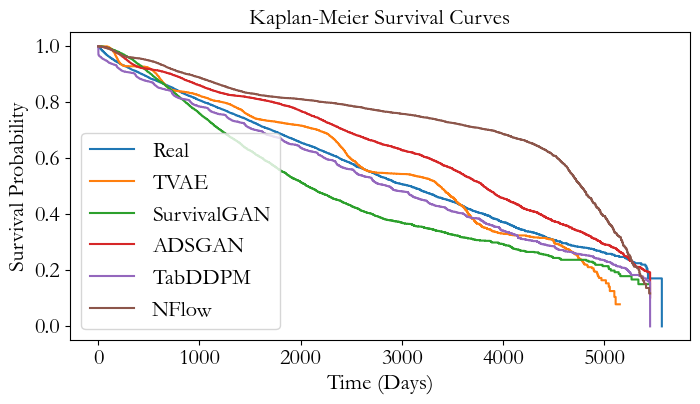

In [12]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
# Initialize the KaplanMeierFitter
plt.rcParams.update({'font.size': 14})  # Change 14 to your desired size
plt.rcParams['font.family'] = 'garamond'
fig, ax = plt.subplots(figsize=(8, 4))

kmf_single = KaplanMeierFitter()

datasets = {
    'Real': real_baseline_df,
    'TVAE': tvae_df,
    'SurvivalGAN': survadgan_df,
    'ADSGAN': adgan_df,
    # 'CTGAN': cgan_df,
    'TabDDPM': ddpm_df,
    'NFlow': nflow_df,
}



for data in datasets:
    gdmt_data = datasets[data]
    kmf_single.fit(durations=gdmt_data['Days'], event_observed=gdmt_data['dead'])

    # change label to dataset name
    kmf_single.plot(label=data, ci_show=False)

    # Customize font sizes for specific elements
font = 16
plt.xlabel('Time (Days)', fontsize=font)
plt.ylabel('Survival Probability', fontsize=font)
plt.title('Kaplan-Meier Survival Curves', fontsize=font)
plt.legend(fontsize=font)
plt.tick_params(axis='both', which='major', labelsize=font)
plt.savefig("results/survival_km_distance.png", dpi=800, bbox_inches='tight')
plt.show()

In [13]:
#Survival Features 
from lifelines import CoxPHFitter

dataset_names = ['real', 'cgan', 'survadgan', 'adgan', 'tvae', 'ddpm']

datasets = {
    'Real': (real_baseline_df.set_index('ENC_HN', drop=True), real_train_idx, real_val_idx, real_test_idx),
    'TVAE': (tvae_df, tvae_train_idx, tvae_val_idx, tvae_test_idx),
    'SurvivalGAN': (survadgan_df, survadgan_train_idx, survadgan_val_idx, survadgan_test_idx),
    'ADSGAN': (adgan_df, adgan_train_idx, adgan_val_idx, adgan_test_idx),
    # 'CTGAN': (cgan_df, cgan_train_idx, cgan_val_idx, cgan_test_idx),
    'TabDDPM': (ddpm_df, ddpm_train_idx, ddpm_val_idx, ddpm_test_idx),
    'NFlow': (nflow_df, nflow_train_idx, nflow_val_idx, nflow_test_idx)
}
survival_summary = {}
real_sig = None
event_col = 'dead'
for train_name in datasets:
    print(train_name)
    df, train_df, val_df, test_df = datasets[train_name]


    train_df = df.loc[train_df].reset_index(drop=True)
    val_df = df.loc[val_df].reset_index(drop=True)
    test_df = df.loc[test_df].reset_index(drop=True)

    train_df = pd.concat([train_df, val_df, test_df], axis=0).reset_index(drop=True)

    model = CoxPHFitter()
    model.fit(train_df, duration_col='Days', event_col=event_col)
    # save_plot(model=model, model_label="Cox", train_label=train_name, event_col=event_col, out_dir=f'survival_results_{method}')

    model_summary = model.summary.copy()
    model_summary['significant'] = model_summary['p'] < 0.05

    key = f"{train_name}"
    survival_summary[key] = model_summary

    if train_name == "Real":
        real_sig = model_summary['significant']
        real_coef = np.sign(model_summary['coef'])

recall = {}
precision = {}
for model, s_df in survival_summary.items():
    if model == f"Real" or real_sig is None:
        continue
    synth_sig = s_df["significant"]
    synth_coef = np.sign(s_df["coef"])
    same_sign = (np.sign(synth_coef) == np.sign(real_coef))
    test_positive = synth_sig & same_sign
    test_negative = ~test_positive

    tp = (test_positive & real_sig).sum()
    fp = (test_positive & ~real_sig).sum()
    fn = (test_negative & real_sig).sum()
    tn = (test_negative & ~real_sig).sum()
    recall[model] = tp / real_sig.sum() if real_sig.sum() > 0 else 0
    precision[model] = tp / (tp + fp) if (tp + fp) > 0 else 0

recall_df = pd.DataFrame(recall.items(), columns=["Model", "Recall"]).set_index("Model")
precision_df = pd.DataFrame(precision.items(), columns=["Model", "Precision"]).set_index("Model")
recall_df = recall_df.join(precision_df, rsuffix="_precision")

out_folder = f"survival_results"
os.makedirs(out_folder, exist_ok=True)
output_path = f"{out_folder}/survival_summaries.xlsx"

with pd.ExcelWriter(output_path) as xl:
    recall_df.to_excel(xl, sheet_name="recall of sig features")
    for model, s_df in survival_summary.items():
        s_df.to_excel(xl, sheet_name=f"{model[:25]}")

print(f"Saved survival summaries to: {os.path.abspath(output_path)}")
recall_df

Real
TVAE
SurvivalGAN
ADSGAN
TabDDPM
NFlow
Saved survival summaries to: d:\dream\my-synthetic\survival_results\survival_summaries.xlsx


,Recall,Precision
Model,,
TVAE,0.782609,0.947368
SurvivalGAN,0.869565,0.833333
ADSGAN,0.652174,0.833333
TabDDPM,0.739130,0.772727
NFlow,0.608696,0.933333


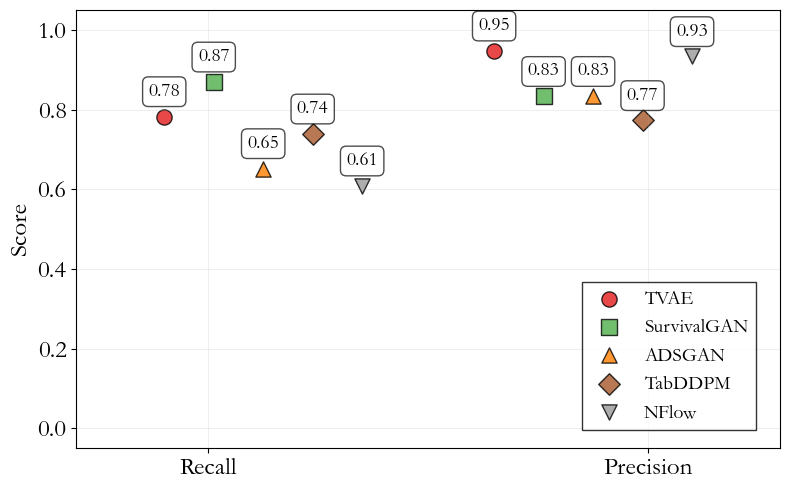

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_scatter_improved(recall_df):
    """
    Create an improved scatter plot with better spacing and visualization
    """
    plt.figure(figsize=(8, 5))
    
    models = recall_df.index
    n_models = len(models)
    
    # Create offset positions for each model to avoid overlap
    recall_positions = np.linspace(-0.1, 0.35, n_models)  # Spread around position 0
    precision_positions = np.linspace(0.65, 1.1, n_models)  # Spread around position 1
    
    # Use distinct colors and markers for each model
    colors = plt.cm.Set1(np.linspace(0, 1, n_models))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    # Plot each model's metrics
    for i, model in enumerate(models):
        recall_val = recall_df.loc[model, 'Recall']
        precision_val = recall_df.loc[model, 'Precision']
        
        # Plot recall point
        plt.scatter(recall_positions[i], recall_val, 
                   s=120, alpha=0.8, c=[colors[i]], 
                   marker=markers[i % len(markers)], 
                   label=f'{model}', edgecolors='black', linewidth=1)
        
        # Plot precision point
        plt.scatter(precision_positions[i], precision_val, 
                   s=120, alpha=0.8, c=[colors[i]], 
                   marker=markers[i % len(markers)], 
                   edgecolors='black', linewidth=1)
        
    plt.ylabel('Score', fontsize=18, fontfamily='Garamond')

    # Set x-axis labels and limits
    plt.xticks([0, 1], ['Recall', 'Precision'], fontsize=18, fontfamily='Garamond')
    plt.yticks(fontsize=18, fontfamily='Garamond')
    plt.xlim(-0.3, 1.3)
    plt.ylim(-0.05, 1.05)
    
    # Add grid
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add legend with larger font size and black border
    legend = plt.legend(loc='lower right', 
                       frameon=True, fancybox=False, shadow=False, 
                       prop={'family': 'Garamond', 'size': 14}, 
                       bbox_to_anchor=(0.98, 0.02),
                       edgecolor='black')
    
    # # Alternative method to ensure font size is applied
    # for text in legend.get_texts():
    #     text.set_fontsize(20)
    
    # Add value annotations
    for i, model in enumerate(models):
        recall_val = recall_df.loc[model, 'Recall']
        precision_val = recall_df.loc[model, 'Precision']
        
        # Annotate with values
        plt.annotate(f'{recall_val:.2f}', 
                    (recall_positions[i], recall_val),
                    xytext=(0, 15), textcoords='offset points', 
                    ha='center', fontsize=14, fontfamily='Garamond',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        plt.annotate(f'{precision_val:.2f}', 
                    (precision_positions[i], precision_val),
                    xytext=(0, 15), textcoords='offset points', 
                    ha='center', fontsize=14, fontfamily='Garamond',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.savefig("results/recall_precision_scatter.png", dpi=800, bbox_inches='tight')
    plt.show()

# Usage example:
plot_scatter_improved(recall_df)

In [7]:
import numpy as np

# combine survival summary into a single DataFrame
data = {}
for model, s_df in survival_summary.items():
    coef_p_str = s_df['coef'].round(3).astype(str) + ' (' + s_df['p'].round(3).astype(str) + ")"
    data[model] = np.where(s_df['p'] < 0.05, coef_p_str + "*", coef_p_str)

survival_coef_df = pd.DataFrame(data)
survival_coef_df

,Real,TVAE,SurvivalGAN,ADSGAN,TabDDPM,NFlow
0,-0.111 (0.003)*,-0.019 (0.638),0.028 (0.441),-0.154 (0.0)*,-0.119 (0.001)*,0.093 (0.029)*
1,-0.247 (0.0)*,-0.323 (0.0)*,-0.37 (0.0)*,-0.165 (0.0)*,-0.277 (0.0)*,-0.109 (0.002)*
2,0.082 (0.351),-0.013 (0.923),0.292 (0.0)*,0.332 (0.0)*,0.252 (0.003)*,0.033 (0.469)
3,-0.177 (0.0)*,-0.313 (0.0)*,-0.196 (0.0)*,-0.193 (0.0)*,-0.196 (0.0)*,-0.052 (0.199)
4,0.149 (0.033)*,0.371 (0.023)*,0.228 (0.0)*,0.239 (0.001)*,0.189 (0.008)*,0.213 (0.0)*
5,0.024 (0.468),-0.111 (0.002)*,0.058 (0.077),0.087 (0.011)*,-0.009 (0.787),0.17 (0.0)*
6,-0.352 (0.0)*,-0.419 (0.0)*,-0.258 (0.0)*,-0.217 (0.0)*,-0.248 (0.0)*,-0.452 (0.0)*
7,-0.255 (0.0)*,-0.365 (0.0)*,-0.222 (0.0)*,-0.193 (0.0)*,-0.076 (0.027)*,0.058 (0.168)
8,0.137 (0.0)*,0.233 (0.0)*,0.171 (0.0)*,0.235 (0.0)*,0.139 (0.0)*,0.345 (0.0)*
9,-0.122 (0.043)*,-0.205 (0.095),0.083 (0.099),0.007 (0.912),-0.202 (0.001)*,-0.066 (0.296)


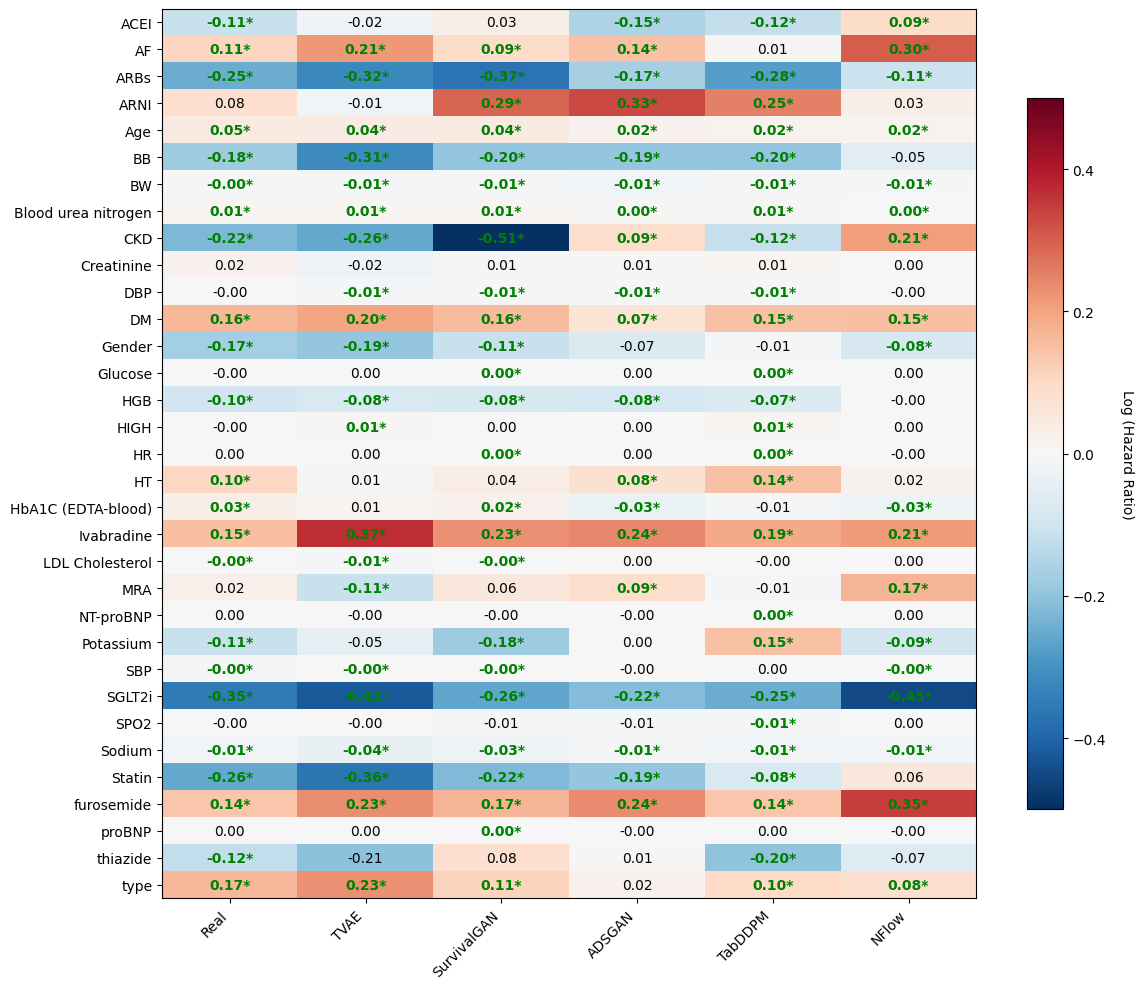

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle

def plot_feature_comparison_heatmap(survival_summary, figsize=(12, 8)):
    """
    Create a heatmap showing hazard ratios across models and features
    """
    # Get all unique features
    all_features = set()
    for model_summary in survival_summary.values():
        all_features.update(model_summary.index.tolist())
    all_features = sorted(list(all_features))
    
    # Create matrix of hazard ratios
    hr_matrix = pd.DataFrame(index=all_features, columns=survival_summary.keys())
    p_matrix = pd.DataFrame(index=all_features, columns=survival_summary.keys())
    
    for model_name, model_summary in survival_summary.items():
        for feature in all_features:
            hr_matrix.loc[feature, model_name] = model_summary.loc[feature, 'coef']
            p_matrix.loc[feature, model_name] = model_summary.loc[feature, 'p']
    
    # Convert to numeric
    hr_matrix = hr_matrix.astype(float)
    p_matrix = p_matrix.astype(float)
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    # Use log scale for hazard ratios
    hr_log = hr_matrix
    
    # Create heatmap
    im = ax.imshow(hr_log.values, cmap='RdBu_r', aspect='auto', 
                   vmin=-0.5, vmax=0.5)  
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Log (Hazard Ratio)', rotation=270, labelpad=20)
    
    # Add text annotations
    for i in range(len(all_features)):
        for j in range(len(survival_summary)):
            if not np.isnan(hr_matrix.iloc[i, j]):
                hr_val = hr_matrix.iloc[i, j]
                p_val = p_matrix.iloc[i, j]
                
                # Format text based on significance
                if p_val < 0.05:
                    text = f'{hr_val:.2f}*'
                    color = 'green'
                else:
                    text = f'{hr_val:.2f}'
                    color = 'black'
                
                ax.text(j, i, text, ha='center', va='center', 
                       color=color, fontweight='bold' if p_val < 0.05 else 'normal')
    
    # Customize axes
    ax.set_xticks(range(len(survival_summary)))
    ax.set_xticklabels(survival_summary.keys(), rotation=45, ha='right')
    ax.set_yticks(range(len(all_features)))
    ax.set_yticklabels(all_features)

    plt.tight_layout()
    
    return fig, ax

# Example usage:
# Assuming survival_summary is available from your code


# Plot 2: Heatmap comparison
fig2, ax2 = plot_feature_comparison_heatmap(survival_summary, figsize=(12, 10))
plt.show()

fig2.savefig('results/survival_heatmap.png', dpi=600, bbox_inches='tight')


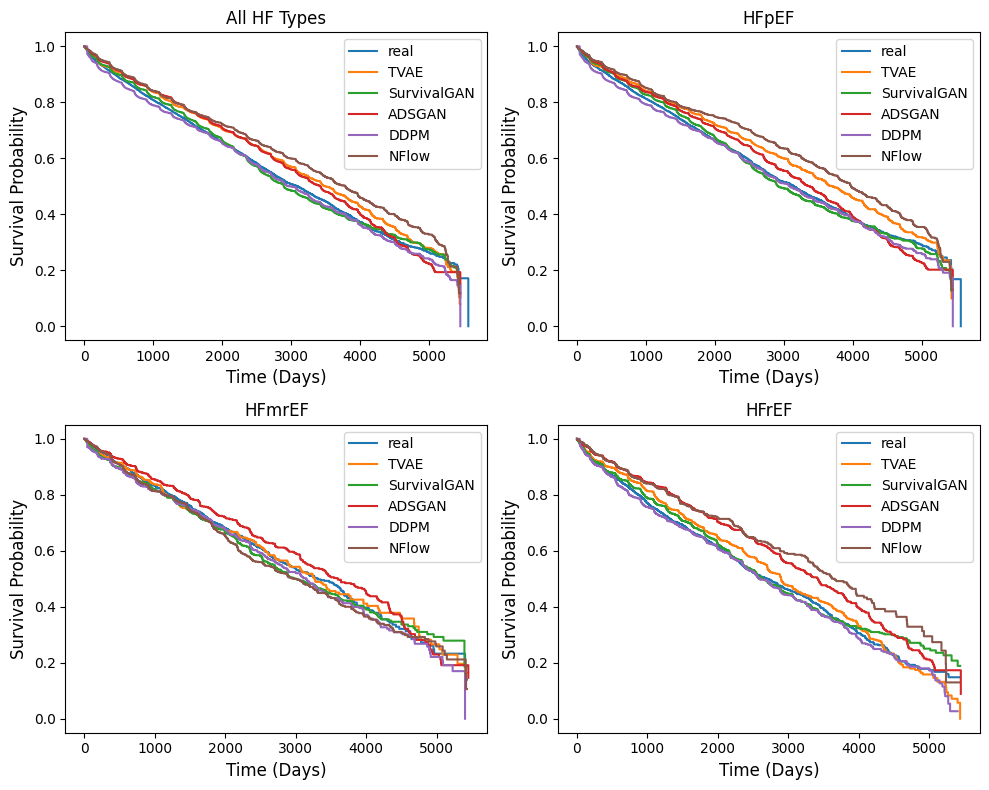

In [4]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Initialize the KaplanMeierFitter
kmf_single = KaplanMeierFitter()

datasets = {
    'real': real_baseline_df,
    'TVAE': tvae_df,
    'SurvivalGAN': survadgan_df,
    'ADSGAN': adgan_df,
    # 'CTGAN': cgan_df,
    'DDPM': ddpm_df,
    'NFlow': nflow_df
}

type_dict = {
    0: 'HFpEF',
    1: 'HFmrEF', 
    2: 'HFrEF',
}

# Create subplots: 2x2 grid (3 types + 1 overall)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
font = 12
# Plot KM curve for entire dataset (4th subplot)
ax = axes[0]
for data in datasets:
    tmp_data = datasets[data]
    kmf_single.fit(durations=tmp_data['Days'], event_observed=tmp_data['dead'])
    kmf_single.plot(ax=ax, label=f'{data}', ci_show=False)
ax.set_title("All HF Types")
ax.legend()
ax.set_xlabel('Time (Days)', fontsize=font)
ax.set_ylabel('Survival Probability', fontsize=font)
# Plot KM curves for each type
for i, key in enumerate(type_dict.keys()):
    ax = axes[i+1]
    
    for data in datasets:
        tmp_data = datasets[data][(datasets[data]['type'] == key).values]
        kmf_single.fit(durations=tmp_data['Days'], event_observed=tmp_data['dead'])
        kmf_single.plot(ax=ax, label=f'{data}', ci_show=False)
    
    ax.set_title(f"{type_dict[key]}")
    ax.legend()
    ax.set_xlabel('Time (Days)', fontsize=font)
    ax.set_ylabel('Survival Probability', fontsize=font)

plt.tight_layout()
plt.savefig("results/survival_km_distance_by_type.png", dpi=800, bbox_inches='tight')
plt.show()

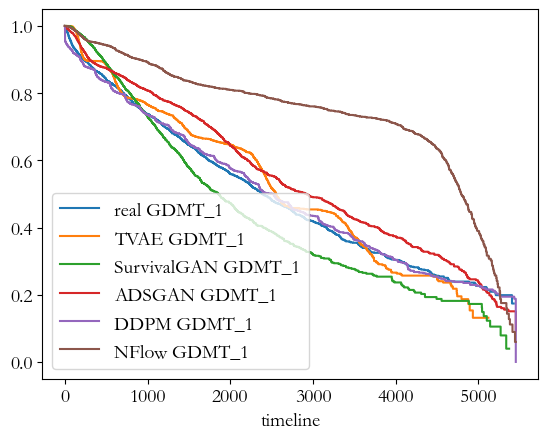

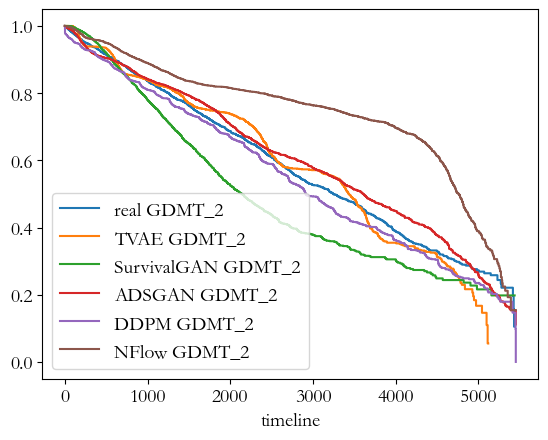

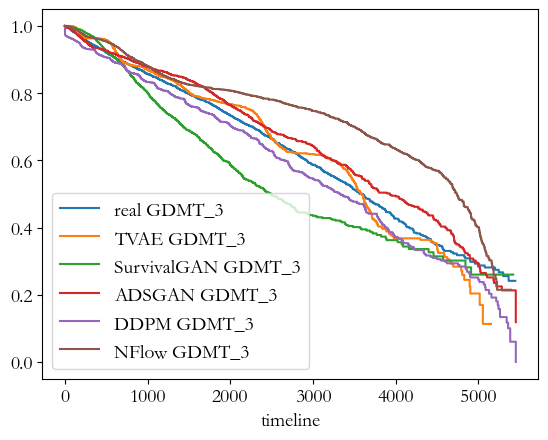

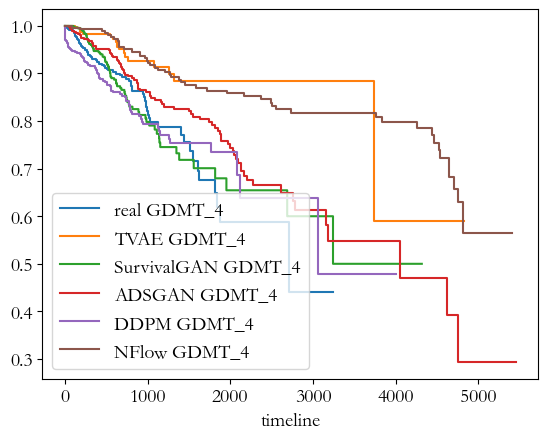

In [39]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
# Initialize the KaplanMeierFitter
kmf_single = KaplanMeierFitter()

datasets = {
    'real': real_baseline_df,
    'TVAE': tvae_df,
    'SurvivalGAN': survadgan_df,
    'ADSGAN': adgan_df,
    # 'CTGAN': cgan_df,
    'DDPM': ddpm_df,
    'NFlow': nflow_df
}

gdmt = {
    1: ['ACEI', 'ARBs', 'ARNI'],
    2: ['BB'],
    3: ['SGLT2i'],
    4: ['MRA']
}

for key in gdmt.keys():
    for data in datasets:

        datasets[data][f'GDMT_{key}'] = datasets[data][gdmt[key]].any(axis=1).astype(int)


for data in datasets:
    datasets[data]['GDMT'] = datasets[data][[f'GDMT_{i}' for i in range(1, 5)]].sum(axis=1)


for i in range(1, 5):
    for data in datasets:
        gdmt_data = datasets[data][datasets[data][f'GDMT'] == i]
        kmf_single.fit(durations=gdmt_data['Days'], event_observed=gdmt_data['dead'])

        # change label to dataset name
        kmf_single.plot(label=f'{data} GDMT_{i}', ci_show=False)
    plt.show()

In [21]:
import config
import pandas as pd
import numpy as np

In [81]:
df = pd.read_parquet(config.PARQUET_FILE)
df.sort_values(by=['ENC_HN', 'REC_DATE'], inplace=True)
df = df.groupby('ENC_HN').first(skipna = False)
df[(df['ef'] >50) & (df['type'] !='P')]

,REC_DATE,ACEI,ARBs,ARNI,BB,Ivabradine,MRA,SGLT2i,Statin,Vericiguat,...,ef,HT,DM,AF,CKD,gender,age,dead,type,Gender
ENC_HN,,,,,,,,,,,,,,,,,,,,,


In [34]:
from skimage.exposure import match_histograms

In [36]:
use_index = np.concatenate([real_train_idx, real_val_idx])
array1_matched = match_histograms(survadgan_df['Days'].to_numpy(), real_baseline_df['Days'][real_baseline_df['ENC_HN'].isin(use_index)].to_numpy())

In [37]:
array1_matched

array([ 924.05887508, 2341.45073067,   31.36452358, ..., 1183.01386233,
        750.66300191, 1406.67375717])

In [31]:
import numpy as np
from scipy import interpolate

def histogram_matching(source, reference):
    """Transform source distribution to match reference distribution"""
    
    # Sort both arrays
    source_sorted = np.sort(source)
    reference_sorted = np.sort(reference)
    
    # Calculate CDFs
    source_cdf = np.linspace(0, 1, len(source_sorted))
    reference_cdf = np.linspace(0, 1, len(reference_sorted))
    
    # Create inverse mapping from reference CDF
    # Map each value in source to corresponding percentile in reference
    source_ranks = np.argsort(np.argsort(source))  # Ranks of original source
    percentiles = source_ranks / (len(source) - 1)  # Convert to percentiles
    
    # Interpolate reference values at these percentiles
    matched_values = np.interp(percentiles, reference_cdf, reference_sorted)
    
    return matched_values

# Apply transformation
use_index = np.concatenate([real_train_idx, real_val_idx])
array1_matched = histogram_matching(survadgan_df['Days'], real_baseline_df['Days'][real_baseline_df['ENC_HN'].isin(use_index)])

In [30]:
real_baseline_df

,ENC_HN,ACEI,ARBs,ARNI,BB,Ivabradine,MRA,SGLT2i,Statin,furosemide,...,proBNP,HT,DM,AF,CKD,type,Gender,Age,Days,dead
0,0008C6FB6B8B6A6341009E1F07FC9D51D0E445DA30327E6150EABACEFAD5EDB3,0,0,0,1,0,1,0,0,1,...,20156.371019,1,0,0,0,0,1,83,919.0,1
1,000923D65E6A6124602952D7634EC57BAFA1CE74D3E9315E107105E005C6E3CC,1,0,0,1,0,1,0,1,0,...,4132.000000,1,0,1,0,1,0,67,1312.0,1
2,0009D8E54DC2780335C739E70299C75A678514FDB6534D0A5BBE647353F4B1A9,0,0,1,1,0,1,0,1,1,...,13038.544149,1,1,1,1,2,0,57,827.0,1
3,0012EF249E802B6BEF4797BE35D528A1C34CA642403E15056CBAFC52D5E3F175,0,0,0,1,0,1,0,1,1,...,2379.000000,1,0,1,0,0,0,71,2704.0,0
4,00273C1C5DEEA98C695627F12A567409001A1872CC41B3DBF9E9FC3563C04194,0,1,0,1,0,0,0,1,1,...,24624.447929,1,0,0,1,1,0,73,2191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12547,FFEE9ACC5EB538B68F39C827ACAC03C30619EF3352A0A46BAD0523890A699418,0,0,0,1,0,0,1,0,0,...,34352.055833,0,1,0,1,0,0,75,549.0,0
12548,FFF2C19075C14012934F477EC731C8E56C9F353A3A5BEFF27EFCDD5052104DDA,1,0,0,1,0,1,0,0,1,...,14284.427605,1,0,0,0,1,0,53,832.0,0
12549,FFF2F9311614C34C7A8DC99545D6F5992761F4F29DE01EF887E852AA64295DE2,0,1,0,1,0,0,1,1,0,...,28781.938760,1,1,1,1,0,0,88,1036.0,1
12550,FFF48680E7E2FA315397FB3FF8ACCCE07EED4061C5CCDA880C6FEFDE282A6062,0,1,0,1,0,0,0,0,1,...,1.000000,1,0,1,1,0,1,69,212.0,0


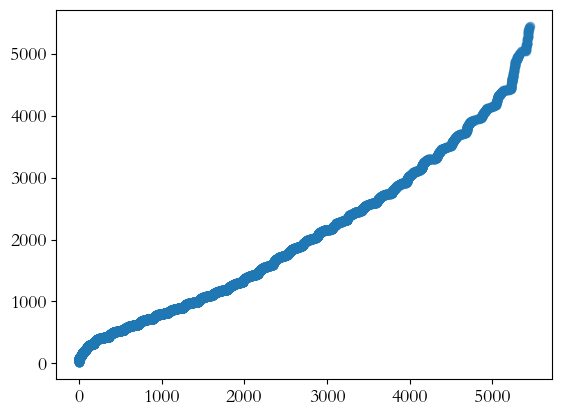

In [38]:
plt.scatter(array1_matched, survadgan_df['Days'], alpha=0.5)

(array([6.46251586e-04, 5.96870236e-04, 2.64798546e-04, 5.48204557e-04,
        3.42806766e-04, 3.62845575e-04, 4.88088130e-04, 1.97525402e-04,
        4.46579169e-04, 3.21336614e-04, 1.83927639e-04, 3.60698560e-04,
        1.88937341e-04, 2.79827653e-04, 2.55494813e-04, 1.33114945e-04,
        3.05591835e-04, 1.97525402e-04, 1.73192562e-04, 2.48338096e-04,
        9.30373269e-05, 2.58357500e-04, 1.74623906e-04, 1.14507479e-04,
        1.82496295e-04, 1.12360464e-04, 1.11644792e-04, 1.29536586e-04,
        7.01358311e-05, 1.29536586e-04, 8.01552355e-05, 6.65574723e-05,
        1.08782105e-04, 5.36753809e-05, 9.73313574e-05, 9.30373269e-05,
        4.65186635e-05, 8.23022507e-05, 4.15089612e-05, 4.93813504e-05,
        6.51261288e-05, 2.21858241e-05, 5.58223962e-05, 2.64798546e-05,
        2.36171676e-05, 4.36559765e-05, 2.93425416e-05, 4.72343352e-05,
        3.14895568e-05, 7.15671746e-07]),
 array([1.00000e+00, 1.12320e+02, 2.23640e+02, 3.34960e+02, 4.46280e+02,
        5.57600e+02, 

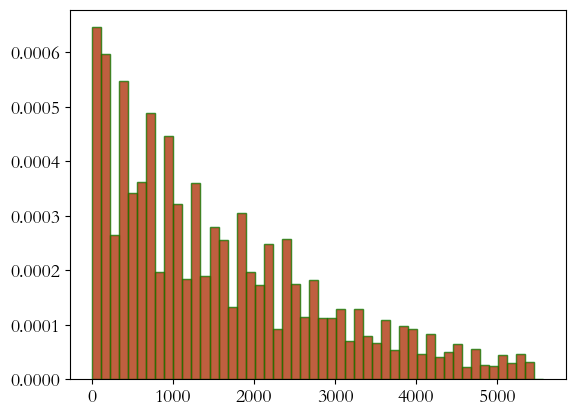

In [23]:
plt.hist(real_baseline_df['Days'], bins=50, alpha=0.5, label='Real', color='green', edgecolor='green', density = True)
plt.hist(array1_matched, bins=50, alpha=0.5, label='Real', color='red', edgecolor='green', density = True)